In [2]:
# Mount Drive
from google.colab import drive
drive.mount('/content/drive', force_remount=True)


ValueError: mount failed

In [1]:
# Imports
import os
import numpy as np
import cv2
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
from tqdm import tqdm


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)


Using device: cuda


In [ ]:
class BrainTumorDataset(Dataset):
    def __init__(self, root_dir, img_size=256):
        self.data = []
        self.img_size = img_size

        for patient in os.listdir(root_dir):
            patient_path = os.path.join(root_dir, patient)
            if not os.path.isdir(patient_path):
                continue

            files = os.listdir(patient_path)

            # image files = .tif but NOT mask
            images = [f for f in files if f.endswith(".tif") and "_mask" not in f]

            for img in images:
                base = img.replace(".tif", "")
                mask = base + "_mask.tif"

                img_path = os.path.join(patient_path, img)
                mask_path = os.path.join(patient_path, mask)

                if os.path.exists(mask_path):
                    self.data.append((img_path, mask_path))

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img_path, mask_path = self.data[idx]

        image = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        mask  = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

        image = cv2.resize(image, (self.img_size, self.img_size))
        mask  = cv2.resize(mask, (self.img_size, self.img_size))

        image = image / 255.0
        mask  = mask / 255.0

        image = torch.tensor(image, dtype=torch.float32).unsqueeze(0)
        mask  = torch.tensor(mask, dtype=torch.float32).unsqueeze(0)

        return image, mask


In [ ]:
DATASET_DIR = "/content/drive/MyDrive/Major_project/brats/kaggle_3m"


In [ ]:
import cv2
import os
import torch
from torch.utils.data import Dataset


In [ ]:
# Dataset
import os

# find the first actual patient directory
for item in os.listdir(DATASET_DIR):
    item_path = os.path.join(DATASET_DIR, item)
    if os.path.isdir(item_path):
        sample_patient = item
        break

print("Sample patient folder:", sample_patient)
print(os.listdir(os.path.join(DATASET_DIR, sample_patient))[:10])


Sample patient folder: TCGA_CS_4941_19960909
['TCGA_CS_4941_19960909_1.tif', 'TCGA_CS_4941_19960909_10.tif', 'TCGA_CS_4941_19960909_10_mask.tif', 'TCGA_CS_4941_19960909_11.tif', 'TCGA_CS_4941_19960909_11_mask.tif', 'TCGA_CS_4941_19960909_12.tif', 'TCGA_CS_4941_19960909_12_mask.tif', 'TCGA_CS_4941_19960909_13.tif', 'TCGA_CS_4941_19960909_13_mask.tif', 'TCGA_CS_4941_19960909_14.tif']


In [ ]:
import os

# find one real patient folder
for item in os.listdir(DATASET_DIR):
    p = os.path.join(DATASET_DIR, item)
    if os.path.isdir(p):
        patient_path = p
        break

print("Sample patient path:", patient_path)
print("Files inside:")
print(os.listdir(patient_path)[:15])


Sample patient path: /content/drive/MyDrive/Major_project/brats/kaggle_3m/TCGA_CS_4941_19960909
Files inside:
['TCGA_CS_4941_19960909_1.tif', 'TCGA_CS_4941_19960909_10.tif', 'TCGA_CS_4941_19960909_10_mask.tif', 'TCGA_CS_4941_19960909_11.tif', 'TCGA_CS_4941_19960909_11_mask.tif', 'TCGA_CS_4941_19960909_12.tif', 'TCGA_CS_4941_19960909_12_mask.tif', 'TCGA_CS_4941_19960909_13.tif', 'TCGA_CS_4941_19960909_13_mask.tif', 'TCGA_CS_4941_19960909_14.tif', 'TCGA_CS_4941_19960909_14_mask.tif', 'TCGA_CS_4941_19960909_15.tif', 'TCGA_CS_4941_19960909_15_mask.tif', 'TCGA_CS_4941_19960909_16.tif', 'TCGA_CS_4941_19960909_16_mask.tif']


In [ ]:
dataset = BrainTumorDataset(DATASET_DIR)
print("Total samples:", len(dataset))


Total samples: 3929


In [ ]:
# DataLoader
from torch.utils.data import DataLoader

train_loader = DataLoader(
    dataset,
    batch_size=8,
    shuffle=True,
    num_workers=2,
    pin_memory=True
)

print("✅ DataLoader ready")


✅ DataLoader ready


In [ ]:
# Unet model
import torch.nn as nn

class UNet(nn.Module):
    def __init__(self):
        super().__init__()

        def block(in_c, out_c):
            return nn.Sequential(
                nn.Conv2d(in_c, out_c, 3, padding=1),
                nn.ReLU(inplace=True),
                nn.Conv2d(out_c, out_c, 3, padding=1),
                nn.ReLU(inplace=True)
            )

        self.enc1 = block(1, 64)
        self.enc2 = block(64, 128)
        self.enc3 = block(128, 256)

        self.pool = nn.MaxPool2d(2)

        self.up = nn.Upsample(scale_factor=2, mode="bilinear", align_corners=True)

        self.dec2 = block(256 + 128, 128)
        self.dec1 = block(128 + 64, 64)

        self.final = nn.Conv2d(64, 1, kernel_size=1)

    def forward(self, x):
        e1 = self.enc1(x)
        e2 = self.enc2(self.pool(e1))
        e3 = self.enc3(self.pool(e2))

        d2 = self.up(e3)
        d2 = self.dec2(torch.cat([d2, e2], dim=1))

        d1 = self.up(d2)
        d1 = self.dec1(torch.cat([d1, e1], dim=1))

        return torch.sigmoid(self.final(d1))


In [ ]:
# Loss func
class DiceLoss(nn.Module):
    def __init__(self, smooth=1e-6):
        super().__init__()
        self.smooth = smooth

    def forward(self, pred, target):
        if target.sum() == 0:
            return torch.tensor(0.0, device=pred.device)

        pred = pred.view(-1)
        target = target.view(-1)

        intersection = (pred * target).sum()
        dice = (2 * intersection + self.smooth) / (
            pred.sum() + target.sum() + self.smooth
        )
        return 1 - dice


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = UNet().to(device)

bce = nn.BCELoss()
dice = DiceLoss()
def combined_loss(pred, target):
    return bce(pred, target) + dice(pred, target)

criterion = combined_loss


optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

print("Using device:", device)


Using device: cuda


In [ ]:
# Training Loop

from tqdm import tqdm

EPOCHS = 15

for epoch in range(EPOCHS):
    model.train()
    epoch_loss = 0

    for images, masks in tqdm(train_loader):
        images = images.to(device)
        masks = masks.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, masks)
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

    print(f"Epoch [{epoch+1}/{EPOCHS}] - Loss: {epoch_loss/len(train_loader):.4f}")


100%|██████████| 492/492 [02:31<00:00,  3.25it/s]


Epoch [1/15] - Loss: 0.8816


100%|██████████| 492/492 [02:30<00:00,  3.28it/s]


Epoch [2/15] - Loss: 0.7666


100%|██████████| 492/492 [02:30<00:00,  3.28it/s]


Epoch [3/15] - Loss: 0.7530


100%|██████████| 492/492 [02:30<00:00,  3.27it/s]


Epoch [4/15] - Loss: 0.7303


100%|██████████| 492/492 [02:29<00:00,  3.29it/s]


Epoch [5/15] - Loss: 0.7220


100%|██████████| 492/492 [02:29<00:00,  3.29it/s]


Epoch [6/15] - Loss: 0.7104


100%|██████████| 492/492 [02:29<00:00,  3.29it/s]


Epoch [7/15] - Loss: 0.7186


100%|██████████| 492/492 [02:29<00:00,  3.29it/s]


Epoch [8/15] - Loss: 0.6977


100%|██████████| 492/492 [02:29<00:00,  3.29it/s]


Epoch [9/15] - Loss: 0.6850


100%|██████████| 492/492 [02:29<00:00,  3.29it/s]


Epoch [10/15] - Loss: 0.6744


100%|██████████| 492/492 [02:29<00:00,  3.29it/s]


Epoch [11/15] - Loss: 0.6365


100%|██████████| 492/492 [02:29<00:00,  3.29it/s]


Epoch [12/15] - Loss: 0.6081


100%|██████████| 492/492 [02:29<00:00,  3.29it/s]


Epoch [13/15] - Loss: 0.6082


100%|██████████| 492/492 [02:29<00:00,  3.29it/s]


Epoch [14/15] - Loss: 0.5958


100%|██████████| 492/492 [02:29<00:00,  3.29it/s]

Epoch [15/15] - Loss: 0.5781


In [ ]:
# Model Saving

import os

MODEL_DIR = "/content/drive/MyDrive/Major_project/saved_models"
os.makedirs(MODEL_DIR, exist_ok=True)

MODEL_PATH = os.path.join(MODEL_DIR, "unet_lgg_final.pth")

torch.save(model.state_dict(), MODEL_PATH)

print("✅ Model saved at:", MODEL_PATH)


NameError: name 'torch' is not defined

In [ ]:
# Dataset statistics (precomputed)
# Empty slices: 2556
# Tumor slices: 1373
# not computing right now as it takes time and wastes GPU power
empty = 0
tumor = 0

for _, mask in dataset:
    if mask.sum() == 0:
        empty += 1
    else:
        tumor += 1

print("Empty slices:", empty)
print("Tumor slices:", tumor)


KeyboardInterrupt: 

In [ ]:
# Model Confirmation

import os

MODEL_PATH = "/content/drive/MyDrive/Major_project/saved_models/unet_lgg.pth"
os.makedirs(os.path.dirname(MODEL_PATH), exist_ok=True)

torch.save(model.state_dict(), MODEL_PATH)
print("✅ Model saved at:", MODEL_PATH)
print("Model file exists:", os.path.exists(MODEL_PATH))


✅ Model saved at: /content/drive/MyDrive/Major_project/saved_models/unet_lgg.pth
Model file exists: True


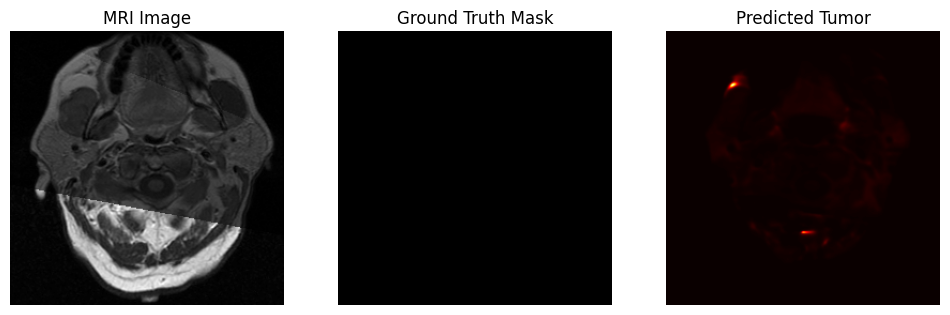

In [ ]:
import matplotlib.pyplot as plt

model.eval()
image, mask = dataset[0]

with torch.no_grad():
    pred = model(image.unsqueeze(0).to(device)).cpu().squeeze().numpy()

plt.figure(figsize=(12,4))

plt.subplot(1,3,1)
plt.imshow(image.squeeze(), cmap="gray")
plt.title("MRI Image")
plt.axis("off")

plt.subplot(1,3,2)
plt.imshow(mask.squeeze(), cmap="gray")
plt.title("Ground Truth Mask")
plt.axis("off")

plt.subplot(1,3,3)
plt.imshow(pred, cmap="hot")
plt.title("Predicted Tumor")
plt.axis("off")

plt.show()


In [ ]:
# find a sample that actually has tumor pixels
for i in range(len(dataset)):
    _, mask = dataset[i]
    if mask.sum() > 0:
        tumor_index = i
        break

print("Tumor slice index:", tumor_index)


Tumor slice index: 2


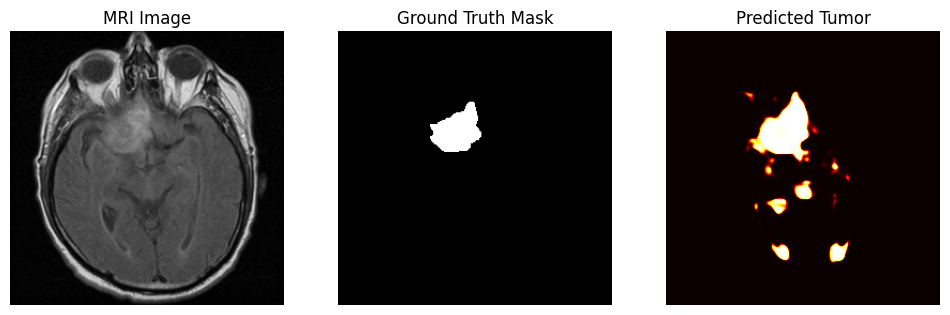

In [ ]:
import matplotlib.pyplot as plt

model.eval()
image, mask = dataset[2]

with torch.no_grad():
    pred = model(image.unsqueeze(0).to(device)).cpu().squeeze().numpy()

plt.figure(figsize=(12,4))

plt.subplot(1,3,1)
plt.imshow(image.squeeze(), cmap="gray")
plt.title("MRI Image")
plt.axis("off")

plt.subplot(1,3,2)
plt.imshow(mask.squeeze(), cmap="gray")
plt.title("Ground Truth Mask")
plt.axis("off")

plt.subplot(1,3,3)
plt.imshow(pred, cmap="hot")
plt.title("Predicted Tumor")
plt.axis("off")

plt.show()


# **PHASE 3 — MODEL EVALUATION & METRICS**

In [ ]:
def detect_tumor(pred, threshold=0.5, min_pixels=50):
    return (pred > threshold).sum() > min_pixels



In [ ]:
model.eval()
image, _ = dataset[2]

with torch.no_grad():
    pred = model(image.unsqueeze(0).to(device))

print("Tumor detected:", detect_tumor(pred))


Tumor detected: tensor(True, device='cuda:0')


In [ ]:
model = UNet().to(device)
model.load_state_dict(torch.load(MODEL_PATH, map_location=device))
model.eval()

print("✅ Trained model loaded for evaluation")


✅ Trained model loaded for evaluation


In [ ]:
def dice_score(pred, target, eps=1e-6):
    pred = pred.view(-1)
    target = target.view(-1)
    intersection = (pred * target).sum()
    return (2 * intersection + eps) / (pred.sum() + target.sum() + eps)


def iou_score(pred, target, eps=1e-6):
    pred = pred.view(-1)
    target = target.view(-1)
    intersection = (pred * target).sum()
    union = pred.sum() + target.sum() - intersection
    return (intersection + eps) / (union + eps)


def precision_recall(pred, target, eps=1e-6):
    tp = ((pred == 1) & (target == 1)).sum().float()
    fp = ((pred == 1) & (target == 0)).sum().float()
    fn = ((pred == 0) & (target == 1)).sum().float()

    precision = tp / (tp + fp + eps)
    recall = tp / (tp + fn + eps)
    return precision.item(), recall.item()


In [ ]:
from torch.utils.data import DataLoader

eval_loader = DataLoader(
    dataset,
    batch_size=8,
    shuffle=False,
    num_workers=2,
    pin_memory=True
)

dice_list = []
iou_list = []
precision_list = []
recall_list = []

with torch.no_grad():
    for images, masks in eval_loader:
        images = images.to(device)

        # FORCE binary ground truth (CRITICAL)
        masks = masks.to(device)
        masks = (masks > 0).float()

        preds = model(images)
        preds_bin = (preds > 0.5).float()

        for i in range(preds_bin.size(0)):
            # evaluate only tumor slices
            if masks[i].sum() == 0:
                continue

            dice_list.append(dice_score(preds_bin[i], masks[i]).item())
            iou_list.append(iou_score(preds_bin[i], masks[i]).item())

            prec, rec = precision_recall(preds_bin[i], masks[i])
            precision_list.append(prec)
            recall_list.append(rec)

print("Tumor slices evaluated:", len(dice_list))
print("Average Dice Score :", sum(dice_list) / len(dice_list))
print("Average IoU Score  :", sum(iou_list) / len(iou_list))
print("Average Precision :", sum(precision_list) / len(precision_list))
print("Average Recall    :", sum(recall_list) / len(recall_list))


Tumor slices evaluated: 1373
Average Dice Score : 0.49000416030179017
Average IoU Score  : 0.375232399045518
Average Precision : 0.6103095625812115
Average Recall    : 0.5122826133364564


In [ ]:
!find /content/drive/MyDrive -name "unet_model.pth"
